In [1]:
from Bio.PDB import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.spatial.distance import cdist
mpl.rcParams['axes.linewidth'] = 1.6
Z=16
from pdbids import pdb_ids
# Wether to download local copies of the PDB files or not
DOWNLOAD_PDBS = True

# Defines binding pocket as the residues with atoms within DISTANCE_THRESHOLD from the cocrystalized catecholamine
DISTANCE_THRESHOLD = 5 # angstroms

In [2]:
# Counts number of crystals with each substrate
n=0
for pdb in pdb_ids.keys():
    n+=len(pdb_ids[pdb])
    print(pdb, len(pdb_ids[pdb]))
print("Total PDB structures:", n)

PHE 67
PEA 8
1WE 2
TYR 57
AEF 3
OTR 6
DAH 5
LDP 13
LNR 7
ALE 3
YTX 1
Total PDB structures: 172


In [3]:
# Ligands to consider in the residue analysis
LIGS = ['PHE','PEA','1WE','TYR','AEF','OTR','DAH','LDP','LNR','ALE','YTX']

In [6]:
# Downloads PDB files to ./pdbs/
pdbl = PDBList()
if DOWNLOAD_PDBS:
    for LIG in LIGS:
        for pdb_name in pdb_ids[LIG]:
            pdbl.retrieve_pdb_file(pdb_name, pdir = './pdbs/{}'.format(LIG), file_format = 'pdb')

Structure exists: './pdbs/PHE\pdb6uob.ent' 
Structure exists: './pdbs/PHE\pdb6vh5.ent' 
Structure exists: './pdbs/PHE\pdb1amu.ent' 
Structure exists: './pdbs/PHE\pdb1b70.ent' 
Structure exists: './pdbs/PHE\pdb1c1d.ent' 
Structure exists: './pdbs/PHE\pdb6eei.ent' 
Structure exists: './pdbs/PHE\pdb1og0.ent' 
Structure exists: './pdbs/PHE\pdb1ofr.ent' 
Structure exists: './pdbs/PHE\pdb1i7a.ent' 
Structure exists: './pdbs/PHE\pdb1tdo.ent' 
Structure exists: './pdbs/PHE\pdb1kfl.ent' 
Structure exists: './pdbs/PHE\pdb6d6n.ent' 
Structure exists: './pdbs/PHE\pdb6gg4.ent' 
Structure exists: './pdbs/PHE\pdb5ckv.ent' 
Structure exists: './pdbs/PHE\pdb5ckx.ent' 
Structure exists: './pdbs/PHE\pdb5d04.ent' 
Structure exists: './pdbs/PHE\pdb5d05.ent' 
Structure exists: './pdbs/PHE\pdb5d59.ent' 
Structure exists: './pdbs/PHE\pdb5d58.ent' 
Structure exists: './pdbs/PHE\pdb5czt.ent' 
Structure exists: './pdbs/PHE\pdb5czs.ent' 
Structure exists: './pdbs/PHE\pdb5dcb.ent' 
Structure exists: './pdbs/PHE\pd

In [4]:
# Load PDB files from ./pdbs/
struct = {LIG: [] for LIG in LIGS}
parser = PDBParser(PERMISSIVE = True, QUIET = True)
for LIG in LIGS:
    for pdb_name in pdb_ids[LIG]:
        st = parser.get_structure("{}".format(pdb_name),"./pdbs/{}/pdb{}.ent".format(LIG, pdb_name.lower()))
        struct[LIG].append(st)

In [5]:
def extract_coords(model, ligname):
    """
    model is an object of type Model from the Bio.PDB library
    ligname is the residue name of the substrate in the read file
    Really intricate way of extracting the residue names of the crystal and the coordinates of the protein atoms
    """
    all_resids = [a.parent._id[1] for chain in model.get_chains() for res in chain.get_residues() for a in res.get_atoms()]
    all_residues = [a.parent.resname for chain in model.get_chains() for res in chain.get_residues() for a in res.get_atoms()]
    all_coords = [a.coord for chain in model.get_chains() for res in chain.get_residues() for a in res.get_atoms()]
    
    all_resids = np.array(all_resids)
    all_residues = np.array(all_residues)
    all_coords = np.array(all_coords)
    
    #print(np.sum(all_resids[all_residues==ligname]))
    lig_mask = np.logical_and(all_residues==ligname, all_resids==max(all_resids[all_residues==ligname]))
    apo_mask =np.invert(lig_mask)
    #print(max(all_resids[all_residues==ligname]))
    lig_coords = all_coords[lig_mask]
    apo_coords = all_coords[apo_mask]
    apo_residues = all_residues[apo_mask]
    apo_resids = all_resids[apo_mask]
    apo_residues = np.core.defchararray.add(apo_residues, apo_resids.astype(str))
    return lig_coords, apo_coords, apo_residues

In [6]:
# Extracts the coordinates and residue names from the loaded files
LIG="PEA"
m = list(struct[LIG][5].get_models())[0]
lig_xyz, apo_xyz, apo_res = extract_coords(m, LIG)
#m = list(list(list(list(struct["PHE"][0].get_models())[0].get_chains())[0].get_residues())[-1].get_atoms())[-1]
#for key, val in m.parent.parent.__dict__.items():
#    print(key, val)

In [7]:
# Extracts the residues in nearby the substrates of interest
binding_sites = {LIG : [] for LIG in LIGS}
for LIG in LIGS:
    print(LIG)
    for s, st in enumerate(struct[LIG]):
        print(LIG, st.id)
        lig_coords, apo_coords, apo_residues = extract_coords(list(st.get_models())[0], LIG)
        dists = cdist(lig_coords, apo_coords)
        near_residues = apo_residues[np.where(dists<DISTANCE_THRESHOLD)[1]]
        near_residues = np.unique(near_residues)
        #print(s, st.id, len(near_residues))#, near_residues)
        binding_sites[LIG] += [res[:3] for res in near_residues]

PHE
PHE 6UOB
PHE 6VH5
PHE 1AMU
PHE 1B70
PHE 1C1D
PHE 6EEI
PHE 1OG0
PHE 1OFR
PHE 1I7A
PHE 1TDO
PHE 1KFL
PHE 6D6N
PHE 6GG4
PHE 5CKV
PHE 5CKX
PHE 5D04
PHE 5D05
PHE 5D59
PHE 5D58
PHE 5CZT
PHE 5CZS
PHE 5DCB
PHE 5FII
PHE 6HNV
PHE 5MGH
PHE 5MGW
PHE 5MGU
PHE 6GYP
PHE 1XRM
PHE 1ZEF
PHE 2IID
PHE 2JB2
PHE 2QMX
PHE 4IO7
PHE 4JPX
PHE 4JPY
PHE 3RZI
PHE 3TD9
PHE 3TCY
PHE 4D2C
PHE 2YPO
PHE 2Z3O
PHE 3AYJ
PHE 3BWN
PHE 3MWB
PHE 3NUD
PHE 3LKV
PHE 3MK2
PHE 3B34
PHE 4PPV
PHE 4R2N
PHE 4XN5
PHE 3KGF
PHE 3L4G
PHE 2VBW
PHE 3TK2
PHE 3PCO
PHE 4UC8
PHE 4UC9
PHE 4FXJ
PHE 5NZK
PHE 5OXN
PHE 2FMG
PHE 2EFU
PHE 1F2P
PHE 1W7M
PHE 1USI
PEA
PEA 1D6Z
PEA 1D6Y
PEA 1D6U
PEA 1TNJ
PEA 4OEK
PEA 5GI6
PEA 1UTO
PEA 1UTM
1WE
1WE 4XP9
1WE 4LAR
TYR
TYR 6L1O
TYR 6OTJ
TYR 5UYY
TYR 6EEM
TYR 6EYV
TYR 1J1U
TYR 1S2K
TYR 6BQZ
TYR 6AGM
TYR 6A8Z
TYR 5DCD
TYR 4TS1
TYR 5M8P
TYR 6IFF
TYR 5T95
TYR 5T9F
TYR 5THH
TYR 5IHX
TYR 5IJX
TYR 6HJW
TYR 6HNI
TYR 6U60
TYR 1Y42
TYR 2PV7
TYR 2QAA
TYR 4GRS
TYR 4HSO
TYR 4I4T
TYR 4CSM
TYR 2XII
TYR 2YPQ
TYR 2YPP
TYR

In [8]:
# Prints non-standard residues to check if we are missing anything
AA_names = ['ASP', 'ARG', 'LYS', 'HIS', 'GLU', 'GLN' , 'SER', 'ASN','THR', 'PHE', 'TRP', 'TYR', 'ALA', 'LEU', 'ILE', 'MET', 'VAL', 'GLY' ,'PRO', 'CYS']
frequencies = {aa : 0 for aa in AA_names}
for LIG in LIGS:
    labels, freqs = np.unique(binding_sites[LIG], return_counts=True)
    for lab, freq in zip(labels, freqs):
        try:
            frequencies[lab] += freq
        except:
            print("Strange residue: {}".format(lab))
print(frequencies)

Strange residue:  BA
Strange residue:  MG
Strange residue:  ZN
Strange residue: AMP
Strange residue: EDO
Strange residue: FAD
Strange residue: GOL
Strange residue: HOH
Strange residue: LLP
Strange residue: MSE
Strange residue: NAI
Strange residue: PLP
Strange residue: PMP
Strange residue: PO4
Strange residue: PPY
Strange residue: SO4
Strange residue: COA
Strange residue: HEM
Strange residue: HOH
Strange residue:  NA
Strange residue: HOH
Strange residue:  CL
Strange residue:  ZN
Strange residue: EDO
Strange residue: HOH
Strange residue: LLP
Strange residue: MDO
Strange residue: MSE
Strange residue: NAD
Strange residue: NAP
Strange residue: PEG
Strange residue: PMP
Strange residue: PO4
Strange residue: SO4
Strange residue: HOH
Strange residue: NAP
Strange residue:  DA
Strange residue:  DC
Strange residue: HEM
Strange residue: HOH
Strange residue: OTS
Strange residue: SAH
Strange residue: VO4
Strange residue:  FE
Strange residue:  ZN
Strange residue: FE2
Strange residue: HOH
Strange resid

/var/folders/rx/y661s_v17xsf84wp1l5rc16h0000gn/T/ipykernel_92311/758430568.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([k[0]+k[1:].lower() for k in frequencies.keys()], rotation=90)


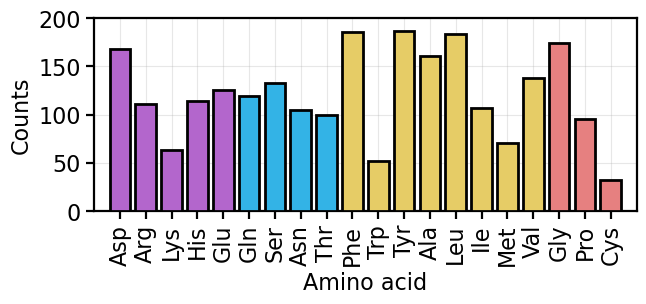

In [9]:
# Plot frequency of each amino acid in all the crystals analyzed
c_charge = [(0.7,0.4,0.8)]*5
c_polar = [(0.2,0.7,0.9)]*4
c_phobic = [(0.9,0.8,0.4)]*8
c_special = [(0.9,0.5,0.5)]*3
colors = c_charge + c_polar + c_phobic + c_special

fig, ax = plt.subplots(figsize=(7,2.5))
ax.tick_params(labelsize=Z, size=6, width=1.6)
ax.set_ylim(0,200)
ax.set_xlim(-1,20)
ax.grid(alpha=0.3, zorder=1)
ax.set_xticklabels([k[0]+k[1:].lower() for k in frequencies.keys()], rotation=90)
ax.set_xlabel("Amino acid", fontsize=Z)
ax.set_ylabel("Counts", fontsize=Z)
ax.bar(frequencies.keys(), frequencies.values(), zorder=3, color=colors, edgecolor='k', lw=2)
# plt.savefig("bindingsites.png", format='png', dpi=300, bbox_inches='tight')
# plt.savefig("bindingsites.svg", format='svg', bbox_inches='tight')
# svg2emf("bindingsites.svg")
plt.show()
plt.close()

In [10]:
print(frequencies)

{'ASP': 168, 'ARG': 111, 'LYS': 63, 'HIS': 114, 'GLU': 125, 'GLN': 119, 'SER': 133, 'ASN': 105, 'THR': 99, 'PHE': 186, 'TRP': 52, 'TYR': 187, 'ALA': 161, 'LEU': 184, 'ILE': 107, 'MET': 70, 'VAL': 138, 'GLY': 174, 'PRO': 95, 'CYS': 32}


In [15]:
# This is just a mini script to see how the total number of amino acid combinations is reduced as more conditions are imposed

def filter_q(aa):
    aa_comb = list(itertools.product(aa, repeat=3))
    N=0
    for a1, a2, a3 in aa_comb:
        Q = charges.get(a1, 0) + charges.get(a2, 0) + charges.get(a3,0)
        if Q==-1 and a3 == "ASP" and charges.get(a1, 0) == 0 and charges.get(a2, 0) == 0:
            N+=1
    return N
import itertools

AA = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HID', 'HIE', 'HIP', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']
charges = {'ARG': 1, 'LYS': 1, 'HIP':1, 'ASP':-1, 'GLU':-1}
A3 = list(itertools.product(AA, repeat=3))
n3 = len(A3)
print(n3)

# These residues would result in too polar or synthetically complicated nanoparticles
AA.remove("HID")
AA.remove("HIE")
AA.remove("CYS")
# Glu is excluded because for redundancy with Asp
AA.remove("GLU")
# The next 4 are excluded for redundancy with other amino acids already included
AA.remove("MET")
AA.remove("VAL")
AA.remove("THR")
AA.remove("ASN")
print(filter_q(AA))


10648
100
